In [1]:
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
)

from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
import pandas as pd

from src.data import load_training_data, make_exog_features, split_data, prepare_feature_store_data_for_training
from src.paths import TRANSFORMED_DATA_DIR

In [2]:
data = pd.read_csv(TRANSFORMED_DATA_DIR / "ts_tabular_2022_10_to_2024_11.csv")
data.head()

,datetime,demand,ba_code
0,2022-10-01,51628,AECI
1,2022-10-02,53127,AECI
2,2022-10-03,54708,AECI
3,2022-10-04,53345,AECI
4,2022-10-05,53356,AECI


In [3]:
temp = prepare_feature_store_data_for_training(data)

In [5]:
temp = make_exog_features(temp)
temp.head()

,ba_AECI,ba_AVA,ba_AZPS,ba_BANC,ba_BPAT,ba_CHPD,ba_CISO,ba_CPLE,ba_CPLW,ba_DOPD,...,ba_TPWR,ba_TVA,ba_WACM,ba_WALC,ba_WAUW,exog_is_holiday,exog_month,exog_day_of_week,exog_is_weekend,exog_season
datetime,,,,,,,,,,,,,,,,,,,,,
2022-10-01,51628.0,27070.0,96193.0,46398.0,123905.0,3745.0,592567.0,123640.0,11797.0,4617.0,...,10804.0,348678.0,80299.0,24633.0,1820.0,0,10,5,1,4
2022-10-02,53127.0,28039.0,97208.0,42814.0,125317.0,3655.0,560074.0,124418.0,11759.0,4583.0,...,10773.0,345900.0,79702.0,26100.0,1749.0,0,10,6,1,4
2022-10-03,54708.0,30110.0,96570.0,47041.0,133353.0,3790.0,623658.0,132803.0,12155.0,4732.0,...,11228.0,373596.0,80536.0,25310.0,1915.0,0,10,0,0,4
2022-10-04,53345.0,30764.0,88963.0,48332.0,134664.0,3831.0,654561.0,134430.0,12294.0,4829.0,...,10927.0,378071.0,80522.0,23938.0,1838.0,0,10,1,0,4
2022-10-05,53356.0,30421.0,91984.0,50362.0,135464.0,3815.0,664304.0,136348.0,12482.0,4854.0,...,10962.0,376763.0,81362.0,23839.0,1828.0,0,10,2,0,4


In [2]:
data = load_training_data()
data = make_exog_features(data)
data.head()

,ba_AECI,ba_AVA,ba_AZPS,ba_BANC,ba_BPAT,ba_CHPD,ba_CISO,ba_CPLE,ba_CPLW,ba_DOPD,...,ba_TPWR,ba_TVA,ba_WACM,ba_WALC,ba_WAUW,exog_is_holiday,exog_month,exog_day_of_week,exog_is_weekend,exog_season
datetime,,,,,,,,,,,,,,,,,,,,,
2022-10-01,51628.0,27070.0,96193.0,46398.0,123905.0,3745.0,592567.0,123640.0,11797.0,4617.0,...,10804.0,348678.0,80299.0,24633.0,1820.0,0,10,5,1,4
2022-10-02,53127.0,28039.0,97208.0,42814.0,125317.0,3655.0,560074.0,124418.0,11759.0,4583.0,...,10773.0,345900.0,79702.0,26100.0,1749.0,0,10,6,1,4
2022-10-03,54708.0,30110.0,96570.0,47041.0,133353.0,3790.0,623658.0,132803.0,12155.0,4732.0,...,11228.0,373596.0,80536.0,25310.0,1915.0,0,10,0,0,4
2022-10-04,53345.0,30764.0,88963.0,48332.0,134664.0,3831.0,654561.0,134430.0,12294.0,4829.0,...,10927.0,378071.0,80522.0,23938.0,1838.0,0,10,1,0,4
2022-10-05,53356.0,30421.0,91984.0,50362.0,135464.0,3815.0,664304.0,136348.0,12482.0,4854.0,...,10962.0,376763.0,81362.0,23839.0,1828.0,0,10,2,0,4


In [3]:
# Encoding exog features as categorical for training
data = data.astype({col: "category" for col in data.filter(like="exog_").columns})

In [6]:
data_train, data_test = split_data(temp)

data_train.shape=(396, 58)
data_test.shape=(395, 58)
Train dates : 2022-10-01 00:00:00 --- 2023-10-31 00:00:00   (n=396)
Test dates  : 2023-11-01 00:00:00 --- 2024-11-29 00:00:00   (n=395)


In [7]:
# Setting up forecaster
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=123, verbose=-1, categorical_feaure=data_train.filter(like='exog_').columns.tolist()),
    lags=[*range(1, 183)],
    window_features=RollingFeatures(
        stats=["mean", "mean", "mean", "mean", "std", "std", "std", "std"],
        window_sizes=[7, 30, 182, 365, 7, 30, 182, 365],
    ),  # Rolling means and stds for 1w, 1m, 6m, 12m
    encoding="ordinal",
    transformer_series=StandardScaler(),  # Transforms each target series using standard scaler. Tranformations are applied under the hood when predicting and the prediction itself is returned on the original scale.
    transformer_exog=StandardScaler(),
)

In [ ]:
# Setting up validation
cv = TimeSeriesFold(
    steps=1, 
    initial_train_size=len(data_train),
    refit=True,
    fixed_train_size=False,
    allow_incomplete_fold=True,
)

In [11]:
metrics, backtest_predictions = (
    backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=temp.filter(like="ba_"),
        exog=temp.filter(like="exog_"),
        cv=cv,
        levels=None,
        metric="mean_absolute_error",
        add_aggregated_metric=True,
        n_jobs="auto",
        verbose=False,
        show_progress=True,
        suppress_warnings=False,
    )
)

/Users/douglaslazenby/Documents/Projects/energy-demand-forecasting/.venv/lib/python3.11/site-packages/skforecast/model_selection/_validation.py:638: LongTrainingWarning: The forecaster will be fit 395 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/395 [00:00<?, ?it/s]

In [12]:
metrics[metrics['levels'] == 'average']

,levels,mean_absolute_error
53,average,7714.393004


In [22]:
data_test[sampled_bas]

,ba_TIDC,ba_TVA,ba_PACW,ba_BPAT,ba_SPA
datetime,,,,,
2023-11-01,7322.0,459567.0,58723.0,163584.0,560.0
2023-11-02,7383.0,466525.0,55174.0,153571.0,546.0
2023-11-03,7309.0,431870.0,52755.0,145742.0,545.0
2023-11-04,6703.0,387333.0,48520.0,139123.0,445.0
2023-11-05,6603.0,375912.0,50753.0,143866.0,495.0
...,...,...,...,...,...
2024-11-25,6968.0,403921.0,63025.0,171097.0,610.0
2024-11-26,6972.0,404968.0,64040.0,175234.0,540.0
2024-11-27,6832.0,437471.0,66523.0,178743.0,542.0


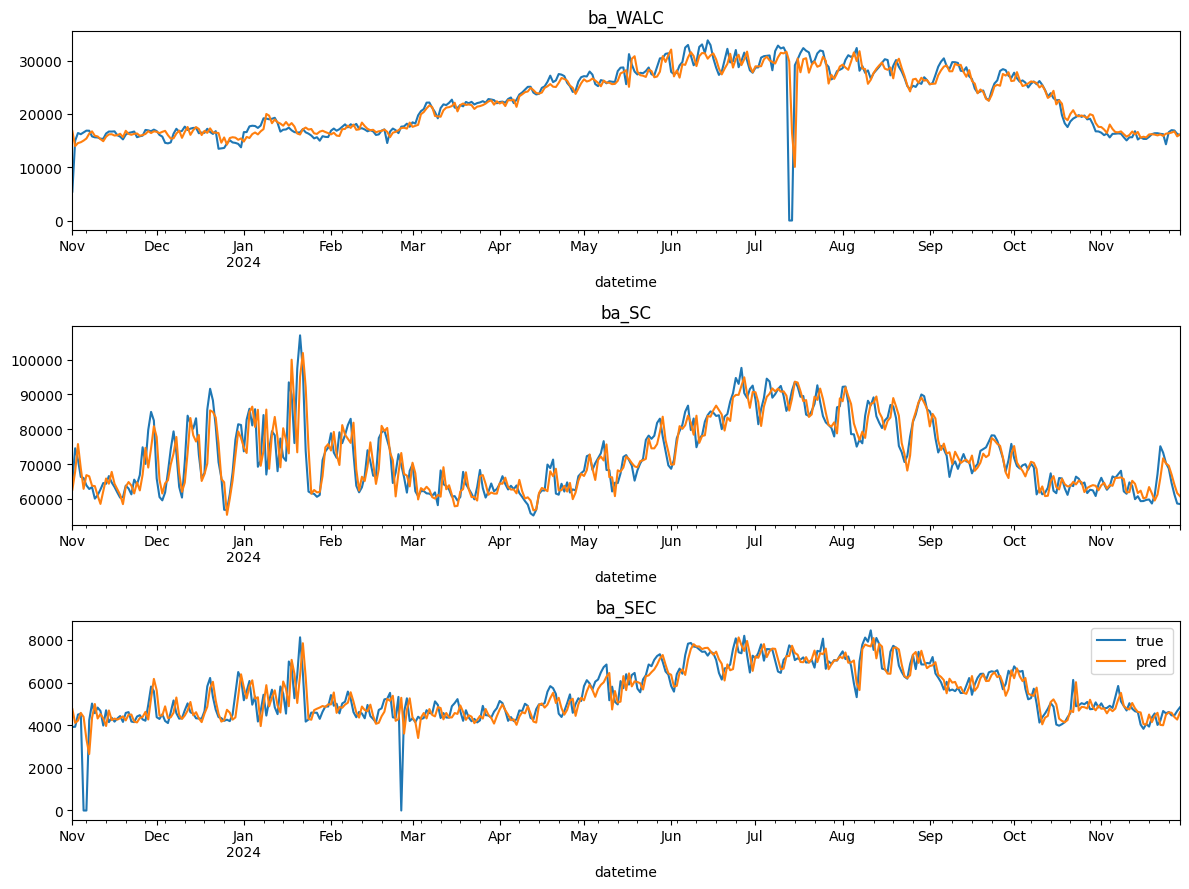

In [39]:
import random
import matplotlib.pyplot as plt
from typing import List

def plot_sampled_bas_with_demand_and_predictions(
    data: pd.DataFrame, 
    predictions: pd.DataFrame, 
    n_samples: int | List[str] = 3):
    
    sampled_bas = random.choices(data.filter(like="ba_").columns, k=n_samples)
    
    _, ax = plt.subplots(figsize=(12, 3 * n_samples), nrows=n_samples)
    for i in range(n_samples):
        data.loc[:, ba := sampled_bas[i]].plot(ax=ax[i], label="true")
        predictions.loc[:, ba].plot(ax=ax[i], label="pred")
        ax[i].set_title(ba)
        
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_sampled_bas_with_demand_and_predictions(data_test, backtest_predictions, 3)

In [15]:
data_test.head()

,ba_AECI,ba_AVA,ba_AZPS,ba_BANC,ba_BPAT,ba_CHPD,ba_CISO,ba_CPLE,ba_CPLW,ba_DOPD,...,ba_TPWR,ba_TVA,ba_WACM,ba_WALC,ba_WAUW,exog_is_holiday,exog_month,exog_day_of_week,exog_is_weekend,exog_season
datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-01,74719.0,37869.0,75586.0,41192.0,163584.0,6291.0,581167.0,158292.0,15867.0,6911.0,...,13895.0,459567.0,86135.0,5429.0,2236.0,0,11,2,0,4
2023-11-02,64962.0,36243.0,76424.0,41568.0,153571.0,5649.0,590289.0,175089.0,16396.0,6389.0,...,12386.0,466525.0,85659.0,14980.0,2277.0,0,11,3,0,4
2023-11-03,58043.0,33648.0,75987.0,41414.0,145742.0,5585.0,580462.0,170746.0,14825.0,6244.0,...,12160.0,431870.0,83365.0,16412.0,2165.0,0,11,4,0,4
2023-11-04,51220.0,32681.0,74389.0,39564.0,139123.0,5096.0,542774.0,145723.0,13370.0,5911.0,...,10984.0,387333.0,80036.0,16194.0,2015.0,0,11,5,1,4
2023-11-05,54544.0,32567.0,79871.0,41281.0,143866.0,5399.0,549166.0,141021.0,12127.0,6120.0,...,11644.0,375912.0,85442.0,16537.0,2035.0,0,11,6,1,4


In [14]:
backtest_predictions.head()

,ba_AECI,ba_AVA,ba_AZPS,ba_BANC,ba_BPAT,ba_CHPD,ba_CISO,ba_CPLE,ba_CPLW,ba_DOPD,...,ba_SWPP,ba_TAL,ba_TEC,ba_TEPC,ba_TIDC,ba_TPWR,ba_TVA,ba_WACM,ba_WALC,ba_WAUW
2023-11-01,73955.924387,37538.948666,75118.645886,40409.747250,169547.644261,6630.538190,574724.888921,136770.692089,12701.622353,6883.089040,...,769972.490962,6844.594884,57865.373423,33121.633635,7279.458395,14504.116814,423344.351854,86960.390580,16775.614512,2097.971662
2023-11-02,75078.812612,37291.574502,76150.470884,41747.824995,162443.569906,6347.149008,579290.767440,158661.820860,15120.019645,6920.309814,...,745963.179720,6277.889267,50749.260103,33320.626505,7086.349929,13882.224575,460995.464417,84834.453443,13955.874456,2335.799863
2023-11-03,58015.160396,35839.172679,74923.535797,41350.310185,150920.664779,5604.684090,586006.034507,182093.297028,15361.866908,6143.796749,...,700124.752729,6802.679029,48456.307637,32939.961983,6987.857206,12297.257421,454996.277336,85282.814440,14526.322597,2245.668614
2023-11-04,53272.057389,32178.234679,75026.324922,39979.805398,140053.316319,5295.428944,555017.901117,160513.399832,14375.314735,5891.417902,...,658693.265047,6341.066111,49009.646050,32538.467839,6777.582722,11616.638199,406448.392182,79535.644034,14686.272228,2058.742034
2023-11-05,49486.873564,32656.692576,73697.502408,38627.253484,136102.600116,4812.897649,529014.053338,135171.584622,12472.965869,5601.698736,...,626711.178127,5896.318025,48018.879880,32493.036458,6470.845225,10966.586979,370875.436298,78642.573478,14992.570672,1878.666447


This is better than the naive baseline we established. 

Now do a quick check of feature importances.

In [30]:
forecaster.fit(
    series=data.filter(like="ba_"),
    exog=data.filter(like="exog_"),
)

forecaster.get_feature_importances()

,feature,importance
0,lag_1,280
193,exog_day_of_week,142
1,lag_2,78
186,roll_std_7,37
5,lag_6,36
...,...,...
170,lag_171,3
71,lag_72,2
190,_level_skforecast,1
134,lag_135,0


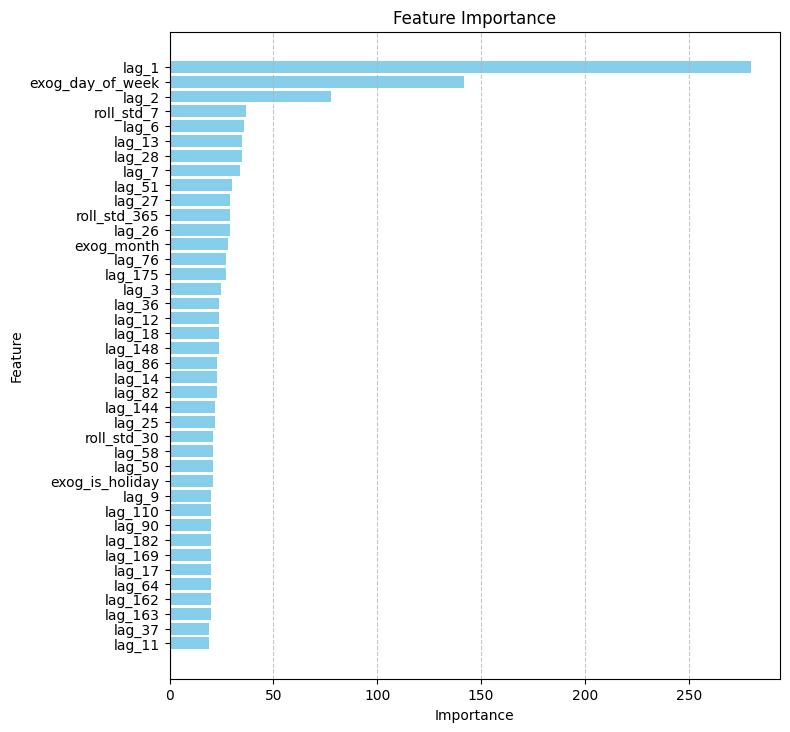

In [41]:
import matplotlib.pyplot as plt

df = forecaster.get_feature_importances().nlargest(40, columns='importance')
df = df.sort_values(by="importance", ascending=True)

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(df["feature"], df["importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.gcf().set_size_inches(8, len(df) * 0.2)
plt.show()